In [30]:
import time
import pandas as pd
import numpy as np
import math
import optuna
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

## Load datasets

In [2]:
# Load datasets
# Train Data
temp_df = pd.read_csv("../data/cleaned/train.csv", nrows=0)  # Read only the header
total_columns = len(temp_df.columns)
columns_to_use = temp_df.columns[1:total_columns]
train_data = pd.read_csv("../data/cleaned/train.csv", usecols=columns_to_use)

# Test Data
test_data = pd.read_csv("../data/cleaned/test.csv", usecols=columns_to_use)

## Process datasets

In [3]:
# *** Do not drop 'date' column yet ***
train_data = train_data.drop(columns=['building_name', 'site_name', 'sqft'])
test_data = test_data.drop(columns=['building_name', 'site_name', 'sqft'])

# Convert 'date' column to datetime
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

# Define the meters to filter by
selected_meters = ['chilledwater', 'hotwater', 'electricity', 'gas']

# Filter train and test data for selected meters
train_data = train_data[train_data['meter'].isin(selected_meters)]
test_data = test_data[test_data['meter'].isin(selected_meters)]



# Building index on building_id for further assessment
train_data.set_index('building_id', inplace=True)
test_data.set_index('building_id', inplace=True)

# Define features and types based on dataset
numerical_features = ['sqm', 'airTemperature']
categorical_features = ['sub_primaryspaceusage', 'site_id', 'weekday', 'month']

results = []

### Drop the columns that we may not use during training

In [4]:
train_data.drop(columns=['primaryspaceusage', 'timezone', 'season'], inplace=True)
test_data.drop(columns=['primaryspaceusage', 'timezone', 'season'], inplace=True)

In [5]:
train_data.head()

,meter,date,meter_reading,sub_primaryspaceusage,sqm,airTemperature,month,weekday,site_id
building_id,,,,,,,,,
1,electricity,2016-01-01,2.9050,Education,609.8,5.246861,1,4,1
1,electricity,2016-01-02,2.7700,Education,609.8,5.993973,1,5,1
1,electricity,2016-01-03,2.6725,Education,609.8,5.660314,1,6,1
1,electricity,2016-01-04,4.5650,Education,609.8,5.048507,1,0,1
1,electricity,2016-01-05,4.7825,Education,609.8,4.745567,1,1,1


In [6]:
test_data.head()

,meter,date,meter_reading,sub_primaryspaceusage,sqm,airTemperature,month,weekday,site_id
building_id,,,,,,,,,
1,electricity,2017-01-01,2.1775,Education,609.8,6.313140,1,6,1
1,electricity,2017-01-02,2.7925,Education,609.8,5.297363,1,0,1
1,electricity,2017-01-03,7.1100,Education,609.8,5.970330,1,1,1
1,electricity,2017-01-04,6.8450,Education,609.8,5.959649,1,2,1
1,electricity,2017-01-05,3.9500,Education,609.8,1.717660,1,3,1


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 553758 entries, 1 to 924
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   meter                  553758 non-null  object        
 1   date                   553758 non-null  datetime64[ns]
 2   meter_reading          553758 non-null  float64       
 3   sub_primaryspaceusage  553758 non-null  object        
 4   sqm                    553758 non-null  float64       
 5   airTemperature         553758 non-null  float64       
 6   month                  553758 non-null  int64         
 7   weekday                553758 non-null  int64         
 8   site_id                553758 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 42.2+ MB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551785 entries, 1 to 924
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   meter                  551785 non-null  object        
 1   date                   551785 non-null  datetime64[ns]
 2   meter_reading          551785 non-null  float64       
 3   sub_primaryspaceusage  551785 non-null  object        
 4   sqm                    551785 non-null  float64       
 5   airTemperature         551785 non-null  float64       
 6   month                  551785 non-null  int64         
 7   weekday                551785 non-null  int64         
 8   site_id                551785 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 42.1+ MB


In [9]:
train_data['airTemperature'].describe()

count    553758.000000
mean         14.194236
std           6.803782
min           0.167459
25%           7.845055
50%          13.906962
75%          20.964912
max          25.487445
Name: airTemperature, dtype: float64

In [10]:
unique_meters = train_data['meter'].unique()
unique_meters

array(['electricity', 'chilledwater', 'gas', 'hotwater'], dtype=object)

## Select meter value (type of meter) used for modelling

In [15]:
meter_value = 'hotwater'

## Define Evaluation metrics

In [12]:
# Define custom evaluation metrics
def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return math.sqrt(mse)

def coefficient_of_variation_root_mean_squared_error(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    return rmse / np.mean(y_true) * 100

def mean_bias_error(y_true, y_pred):
    dif = y_true - y_pred
    return np.mean(dif)

def normalized_mean_bias_error(y_true, y_pred):
    dif = y_true - y_pred
    return (np.sum(dif) / (len(y_true) * np.mean(y_true))) * 100

def r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

## Data Preprocessing Functions for Model Training


In [14]:
# Function to preprocess data
def preprocess_data(X, y=None, fit_scaler=False, scaler=None, y_scaler=None):
    # Convert categorical features to 'category' type
    for cat_col in categorical_features:
        X[cat_col] = X[cat_col].astype('category')

    # Log-transform 'sqm' if it's a highly skewed feature
    if 'sqm' in X.columns:
        X['sqm'] = np.log1p(X['sqm'])

    # Scale numerical features
    if fit_scaler:
        scaler = StandardScaler()
        X[numerical_features] = scaler.fit_transform(X[numerical_features])
        
        if y is not None:
            
            # Cap y at the 99th percentile to handle outliers
            cap_value = np.percentile(y, 99)
            y = np.clip(y, None, cap_value)  # Cap extreme values
            
            # Log-transform and scale the target
            y_log = np.log1p(y)
            y_scaler = StandardScaler()
            y_scaled = y_scaler.fit_transform(y_log.values.reshape(-1, 1)).flatten()
            return X, y_scaled, scaler, y_scaler
        else:
            return X, scaler
    else:
        X[numerical_features] = scaler.transform(X[numerical_features])
        
        if y is not None:
            # Log-transform and scale the target using the provided scaler
            y_log = np.log1p(y)
            y_scaled = y_scaler.transform(y_log.values.reshape(-1, 1)).flatten()
            return X, y_scaled
        else:
            return X

## Model Optimization: Hyper-parameter Tuning Using Optuna

In [13]:
# Optuna objective function for hyperparameter tuning
def objective(trial, X_train, y_train, X_valid, y_valid):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        "random_state": 42,
        'boosting_type': 'gbdt',
        'device': 'cpu',
        'verbosity': -1,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2000, 3000),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'learning_rate': 0.01,
        'max_depth': trial.suggest_int('max_depth', 100, 500),
        'max_bin': trial.suggest_int('max_bin', 500, 1000)
    }

    lgb_train = lgb.Dataset(X_train,
                            label=y_train,
                            categorical_feature=categorical_features)
    lgb_valid = lgb.Dataset(X_valid,
                            label=y_valid,
                            categorical_feature=categorical_features,
                            reference=lgb_train)

    model = lgb.train(
        param,
        lgb_train,
        valid_sets=[lgb_valid],
        num_boost_round=1000,
        callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(10)
        ]
    )

    preds = model.predict(X_valid, num_iteration=model.best_iteration)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    return rmse


n_trials = 50
def progress_callback(study, trial):
    # Calculate the progress percentage
    progress = (len(study.trials) / n_trials) * 100
    print(f"Progress: {progress:.2f}% - Trial {len(study.trials)} of {n_trials}")


#### Process data for model optimization

In [16]:
print(f"==============  Processing meter value: {meter_value} =====================")
# Filter data and preprocess
meter_filter = train_data['meter'] == meter_value
X_meter = train_data.loc[meter_filter].drop(columns=['meter_reading', 'meter', 'date'])
y_meter = train_data.loc[meter_filter, 'meter_reading']


# Split Train set (2016) to train and validation set
split_index = int(len(X_meter) * 0.8)
X_train_meter = X_meter.iloc[:split_index]
X_valid_meter = X_meter.iloc[split_index:]
y_train_meter = y_meter.iloc[:split_index]
y_valid_meter = y_meter.iloc[split_index:]

X_train_processed, y_train_scaled, scaler, y_scaler = preprocess_data(
     X_train_meter.copy(), y_train_meter, fit_scaler=True
)
X_valid_processed, y_valid_scaled = preprocess_data(
     X_valid_meter.copy(), y_valid_meter, fit_scaler=False, scaler=scaler, y_scaler=y_scaler
)

==============  Processing meter value: hotwater =====================


In [17]:
print("================= Tunning hyperparameters with Optuna...=====================")
# Hyperparameter tuning with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train_processed, y_train_scaled, X_valid_processed, y_valid_scaled),
                n_trials=n_trials,
                callbacks=[progress_callback])
best_params = study.best_params

print(f"================= Best parameters found by Optuna:{best_params} ============")

[I 2024-11-04 23:30:58,051] A new study created in memory with name: no-name-23dca3e2-7d1f-45e8-9f49-ba49dbe47f7a


================= Tunning hyperparameters with Optuna...=====================
Training until validation scores don't improve for 50 rounds
[10]	valid_0's rmse: 0.901979
[20]	valid_0's rmse: 0.895302
[30]	valid_0's rmse: 0.876039
[40]	valid_0's rmse: 0.853747
[50]	valid_0's rmse: 0.841116
[60]	valid_0's rmse: 0.828624
[70]	valid_0's rmse: 0.819086
[80]	valid_0's rmse: 0.822418
[90]	valid_0's rmse: 0.821837
[100]	valid_0's rmse: 0.816027
[110]	valid_0's rmse: 0.810206
[120]	valid_0's rmse: 0.801818
[130]	valid_0's rmse: 0.797123
[140]	valid_0's rmse: 0.792623
[150]	valid_0's rmse: 0.791275
[160]	valid_0's rmse: 0.786419
[170]	valid_0's rmse: 0.780027
[180]	valid_0's rmse: 0.772166
[190]	valid_0's rmse: 0.771899
[200]	valid_0's rmse: 0.772152
[210]	valid_0's rmse: 0.770104
[220]	valid_0's rmse: 0.769131
[230]	valid_0's rmse: 0.766578
[240]	valid_0's rmse: 0.764139
[250]	valid_0's rmse: 0.76381
[260]	valid_0's rmse: 0.762828
[270]	valid_0's rmse: 0.760461
[280]	valid_0's rmse: 0.759537
[29

[I 2024-11-04 23:31:02,991] Trial 0 finished with value: 0.7473096769208166 and parameters: {'lambda_l1': 8.125712615571022, 'lambda_l2': 5.51597563815243e-06, 'num_leaves': 2010, 'feature_fraction': 0.5245142849896918, 'bagging_fraction': 0.731198360610995, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 109, 'max_bin': 748}. Best is trial 0 with value: 0.7473096769208166.


Progress: 2.00% - Trial 1 of 50


[W 2024-11-04 23:31:20,317] Trial 1 failed with parameters: {'lambda_l1': 0.03863964892644698, 'lambda_l2': 6.2037649647442485, 'num_leaves': 2770, 'feature_fraction': 0.4556871229120653, 'bagging_fraction': 0.9160765541281659, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 369, 'max_bin': 621} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/mnt/d/akl_assgn/Weather-Impact-Longterm-Energy-Prediction-BDG2/env/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1067/2261370492.py", line 4, in <lambda>
    study.optimize(lambda trial: objective(trial, X_train_processed, y_train_scaled, X_valid_processed, y_valid_scaled),
  File "/tmp/ipykernel_1067/3185113118.py", line 30, in objective
    model = lgb.train(
  File "/mnt/d/akl_assgn/Weather-Impact-Longterm-Energy-Prediction-BDG2/env/lib/python3.10/site-packages/lightgbm/engine.py", line 266, in tr

KeyboardInterrupt: 

## Training Models

### Process training data (2016)

In [26]:
print(f"==============  Processing meter value: {meter_value} =====================")
# Filter data and preprocess
meter_filter = train_data['meter'] == meter_value
X_meter = train_data.loc[meter_filter].drop(columns=['meter_reading', 'meter', 'date'])
y_meter = train_data.loc[meter_filter, 'meter_reading']

X_train_full_processed, y_train_full_scaled, scaler, y_scaler = preprocess_data(
    X_meter.copy(), y_meter, fit_scaler=True
)

for col in categorical_features:
    X_train_full_processed[col] = X_train_full_processed[col].astype('category')

==============  Processing meter value: hotwater =====================


In [27]:
X_train_full_processed.head()

,sub_primaryspaceusage,sqm,airTemperature,month,weekday,site_id
building_id,,,,,,
68,Academic,0.584485,-1.315060,1,4,2
68,Academic,0.584485,-1.205252,1,5,2
68,Academic,0.584485,-1.254292,1,6,2
68,Academic,0.584485,-1.344214,1,0,2
68,Academic,0.584485,-1.388739,1,1,2


In [28]:
X_train_full_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42822 entries, 68 to 886
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   sub_primaryspaceusage  42822 non-null  category
 1   sqm                    42822 non-null  float64 
 2   airTemperature         42822 non-null  float64 
 3   month                  42822 non-null  category
 4   weekday                42822 non-null  category
 5   site_id                42822 non-null  category
dtypes: category(4), float64(2)
memory usage: 1.1 MB


### Process test data (2017)

In [20]:
meter_filter = test_data['meter'] == meter_value
X_test_meter = test_data.loc[meter_filter].drop(columns=['meter_reading', 'meter', 'date'])
y_test_meter = test_data.loc[meter_filter, 'meter_reading']

X_test_processed, y_test_scaled = preprocess_data(
    X_test_meter.copy(), y_test_meter, fit_scaler=False, scaler=scaler, y_scaler=y_scaler  
)  # Must use the same scaler as the training set to prevent data leakage

# Ensure that categorical columns in X_test_processed have the same levels as in X_train_processed
for col in categorical_features:
    X_test_processed[col] = X_test_processed[col].astype('category')

In [21]:
X_test_processed.head()

,sub_primaryspaceusage,sqm,airTemperature,month,weekday,site_id
building_id,,,,,,
68,Academic,0.584485,-1.158341,1,6,2
68,Academic,0.584485,-1.307638,1,0,2
68,Academic,0.584485,-1.208727,1,1,2
68,Academic,0.584485,-1.210297,1,2,2
68,Academic,0.584485,-1.833772,1,3,2


In [23]:
X_test_processed.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 42625 entries, 68 to 886
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   sub_primaryspaceusage  42625 non-null  category
 1   sqm                    42625 non-null  float64 
 2   airTemperature         42625 non-null  float64 
 3   month                  42625 non-null  category
 4   weekday                42625 non-null  category
 5   site_id                42625 non-null  category
dtypes: category(4), float64(2)
memory usage: 1.1 MB


### Define Parameters

* Ideally, we would use the parameters obtained from the model optimization process described above.
* However, to save time, we’ve opted to skip the hyperparameter tuning step and instead directly define a set of parameters.

In [24]:
best_params = {
    'num_leaves': 1000,                # Reduce to limit complexity
    'learning_rate': 0.01,           # Lower learning rate
    'max_bin': 512,                   # Reduce max_bin
    'lambda_l1': 0.01,                 # Add L1 regularization
    'lambda_l2': 0.01,                 # Add L2 regularization
    'min_child_samples': 20,          # Increase min_child_samples
    'max_depth': 15,                  # Limit max_depth
}

### Define functions to train the model

In [25]:
# Custom callback to log progress with estimated remaining time
class TimeEstimatorCallback:
    def __init__(self, num_boost_round, display_interval=50):
        self.num_boost_round = num_boost_round
        self.display_interval = display_interval
        self.start_time = None

    def __call__(self, env):
        if env.iteration == 0:
            self.start_time = time.time()
        
        if env.iteration % self.display_interval == 0:
            elapsed_time = time.time() - self.start_time
            average_time_per_iter = elapsed_time / (env.iteration + 1)
            remaining_iters = self.num_boost_round - env.iteration
            estimated_remaining_time = remaining_iters * average_time_per_iter
            
            # Check if evaluation results are available
            if env.evaluation_result_list:
                rmse = env.evaluation_result_list[0][2]
                print(f"[Iteration {env.iteration}] RMSE: {rmse:.4f} "
                      f"| Elapsed: {elapsed_time:.2f}s "
                      f"| Estimated Remaining: {estimated_remaining_time:.2f}s")
            else:
                print(f"[Iteration {env.iteration}] No evaluation results "
                      f"| Elapsed: {elapsed_time:.2f}s "
                      f"| Estimated Remaining: {estimated_remaining_time:.2f}s")

# Function to train the final model with tuned parameters (no validation set)
def train_final_model(X_train, y_train, best_params):
    final_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'device': 'cpu',
        'verbosity': -1,
    }
    final_params.update(best_params)

    # Create the LightGBM training dataset
    lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    
    num_boost_round = 1000

    # Train the model only on the training set, without validation logging
    model = lgb.train(
        final_params,
        lgb_train,
        num_boost_round=num_boost_round,
        valid_sets=[lgb_train],  # Only use the training set here
        callbacks=[
            lgb.log_evaluation(100),            # Log training metrics every 100 rounds
            TimeEstimatorCallback(num_boost_round, 100)  # Estimate time every 50 iterations
        ]
    )

    return model

### Train the model

========== Training the final model ==========================
[Iteration 0] RMSE: 0.9912 | Elapsed: 0.00s | Estimated Remaining: 0.00s
[100]	training's rmse: 0.470025
[Iteration 100] RMSE: 0.4673 | Elapsed: 2.98s | Estimated Remaining: 26.56s
[200]	training's rmse: 0.315297
[Iteration 200] RMSE: 0.3146 | Elapsed: 120.10s | Estimated Remaining: 478.02s
[300]	training's rmse: 0.272787
[Iteration 300] RMSE: 0.2725 | Elapsed: 185.30s | Estimated Remaining: 430.93s
[400]	training's rmse: 0.255082
[Iteration 400] RMSE: 0.2550 | Elapsed: 196.83s | Estimated Remaining: 294.51s
[500]	training's rmse: 0.243209
[Iteration 500] RMSE: 0.2431 | Elapsed: 200.15s | Estimated Remaining: 199.76s
[600]	training's rmse: 0.235101
[Iteration 600] RMSE: 0.2350 | Elapsed: 203.87s | Estimated Remaining: 135.68s
[700]	training's rmse: 0.229161
[Iteration 700] RMSE: 0.2291 | Elapsed: 224.06s | Estimated Remaining: 95.89s
[800]	training's rmse: 0.22498
[Iteration 800] RMSE: 0.2250 | Elapsed: 226.93s | Estimated 

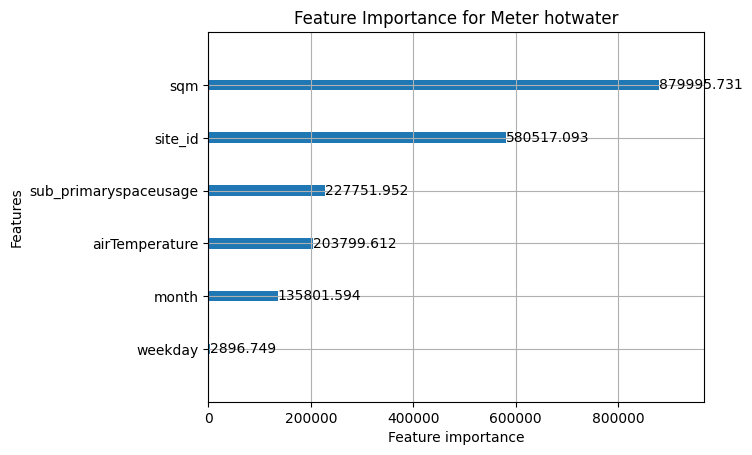

In [ ]:
print("========== Training the final model ==========================")

final_model = train_final_model(X_train_full_processed, y_train_full_scaled, best_params)

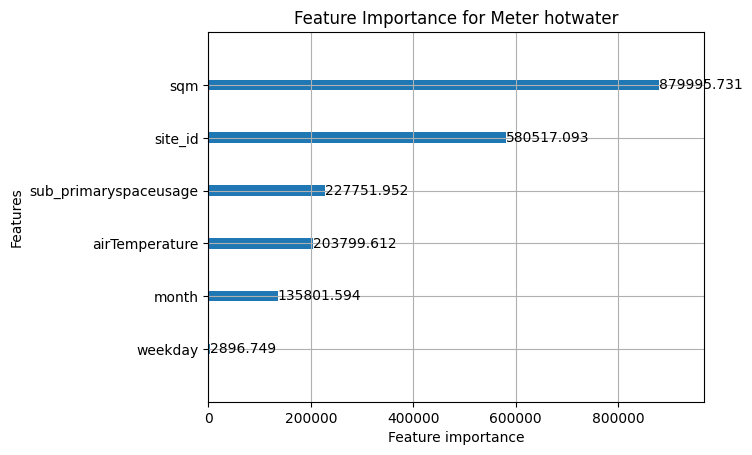

In [31]:
# Plot the feature importance
ax = lgb.plot_importance(final_model, max_num_features=20, importance_type='gain')
plt.title(f"Feature Importance for Meter {meter_value}")
plt.show()

## Check Model Performance on training dataset

### Define functions to evaluate model

In [32]:
def evaluate_model(model, X_test, y_test, y_scaler):
    # Get predictions
    y_pred_scaled = model.predict(X_test)
    y_pred_log = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_pred = np.expm1(y_pred_log).flatten()  # Transform back from log scale

    # Since y_test is already in original scale, no transformation needed
    y_true = y_test

    # Calculate metrics
    rmse = root_mean_squared_error(y_true, y_pred)
    cvrmse = coefficient_of_variation_root_mean_squared_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    nmbe = normalized_mean_bias_error(y_true, y_pred)
    r2 = r_squared(y_true, y_pred)

    # Create the results DataFrame including X_test features
    results_df = pd.DataFrame(X_test).copy()
    results_df['y_true'] = y_true
    results_df['y_pred'] = y_pred

    return rmse, cvrmse, nmbe, mbe, r2, results_df

### Evaluate model on training dataset

In [ ]:
print("Evaluating the model on training set")
# Evaluate the model
rmse, cvrmse, nmbe, mbe, r2, results_df_training = evaluate_model(final_model, X_train_full_processed, y_meter, y_scaler)

# append metrics to 
results_training = []
results_training.append({
    'meter_value': meter_value,
    'best_params': best_params,
    'rmse': rmse,
    'cv-rmse': cvrmse,
    'nmbe': nmbe,
})

print(f"Results for meter {meter_value} on train set:\n \
      RMSE={round(rmse, 4)},\n \
      CV-RMSE={round(cvrmse, 4)} %,\n \
      NMBE={round(nmbe, 4)} %,\n \
      MBE={round(mbe, 4)},\n \
      R2={round(r2, 4)}")


Evaluating the model on training set
Results for meter hotwater on train set:
       RMSE=1233215.679,
       CV-RMSE=129.1221 %,
       NMBE=9.5489 %,
       MBE=91198.8713,
       R2=0.71


### Visualize Prediction versus Actual on training set

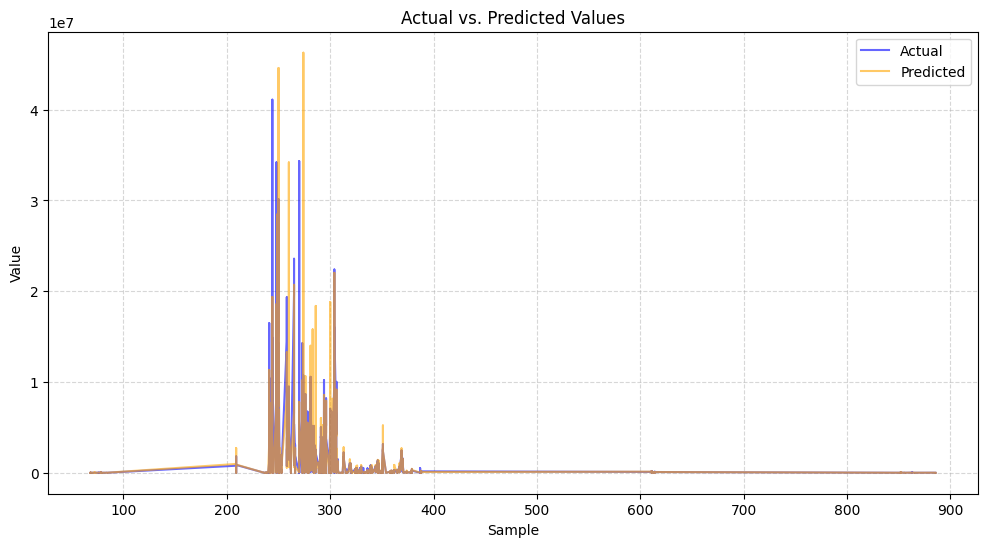

In [38]:
plt.figure(figsize=(12, 6))

# Use contrasting colors and adjust the line width for better visibility
plt.plot(results_df_training['y_true'], label="Actual", color="blue", alpha=0.6, linewidth=1.5)
plt.plot(results_df_training['y_pred'], label="Predicted", color="orange", alpha=0.6, linewidth=1.5)

plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.title("Actual vs. Predicted Values")
plt.grid(True, linestyle='--', alpha=0.5)  # Add a light grid for better readability

plt.show()

## Evaluate model on test set

In [39]:
print("Evaluating the model on test set")
# Evaluate the model
rmse, cvrmse, nmbe, mbe,r2 ,results_df = evaluate_model(final_model, X_test_processed, y_test_meter, y_scaler)

# append metrics to 
results.append({
    'meter_value': meter_value,
    'best_params': best_params,
    'rmse': rmse,
    'cv-rmse': cvrmse,
    'nmbe': nmbe,
    'r2_score': r2
})

print(f"Results for meter {meter_value} on train set:\n \
      RMSE={round(rmse, 4)},\n \
      CV-RMSE={round(cvrmse, 4)} %,\n \
      NMBE={round(nmbe, 4)} %,\n \
      MBE={round(mbe, 4)},\n \
      R2={round(r2, 4)}")

Evaluating the model on test set
Results for meter hotwater on train set:
       RMSE=2255618.2176,
       CV-RMSE=235.735 %,
       NMBE=11.1347 %,
       MBE=106541.9005,
       R2=0.2719


In [40]:
results_df.sample(10)

,sub_primaryspaceusage,sqm,airTemperature,month,weekday,site_id,y_true,y_pred
building_id,,,,,,,,
344,College Laboratory,-0.116796,-0.066936,4,2,7,3.315378e+05,3.112019e+05
284,Office,-1.225161,0.898311,6,4,6,1.534515e+06,3.445548e+04
240,Academic,0.292353,1.072201,8,6,5,1.288369e+02,2.913608e+01
73,Academic,-0.318783,-1.465057,1,6,2,0.000000e+00,4.234728e+02
258,Research,0.703055,0.120782,10,2,6,3.067347e+06,3.242743e+06
291,Office,-0.354810,0.403855,10,2,6,8.517202e+05,6.621057e-01
293,Office,-2.331766,-0.762532,3,4,6,3.262069e+05,2.215925e+05
848,College Laboratory,-1.054885,-0.758438,11,5,15,0.000000e+00,-2.830416e-01
260,Research,0.420899,-0.119519,4,1,6,4.624901e+06,3.080355e+06


In [ ]:
# Convert results to a DataFrame for further analysis
results_df = pd.DataFrame(results)
print("Metrics DataFrame:")
print(results_df)


### Visualize actual versus predictions on test set

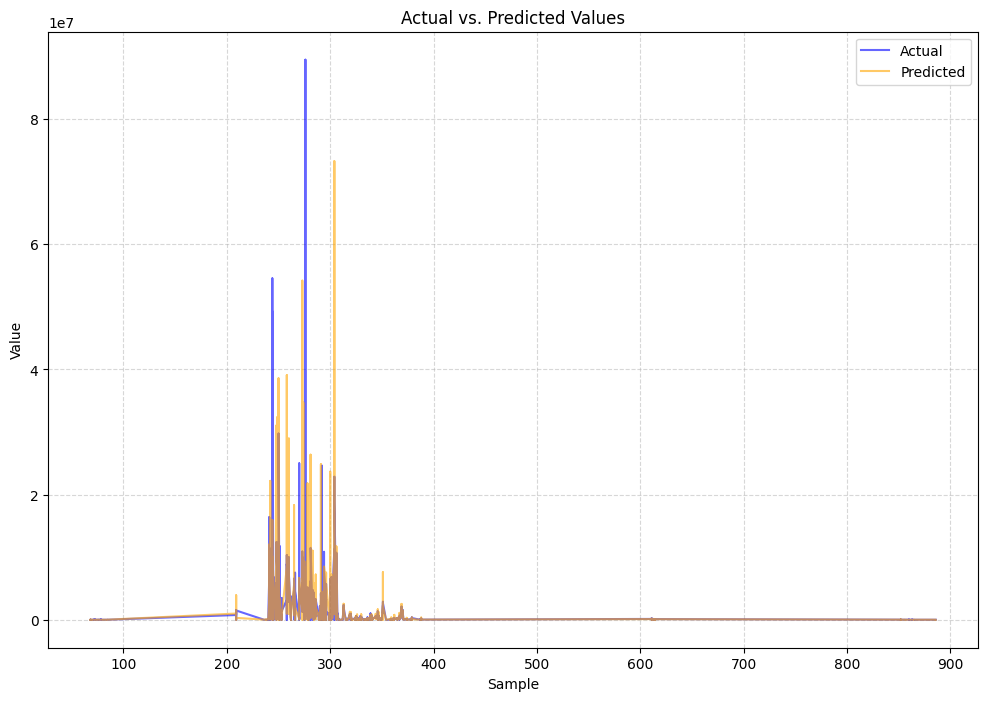

: 

In [ ]:
plt.figure(figsize=(12, 8))

# Use contrasting colors and adjust the line width for better visibility
plt.plot(results_df['y_true'], label="Actual", color="blue", alpha=0.6, linewidth=1.5)
plt.plot(results_df['y_pred'], label="Predicted", color="orange", alpha=0.6, linewidth=1.5)

plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.title("Actual vs. Predicted Values")
plt.grid(True, linestyle='--', alpha=0.5)  # Add a light grid for better readability

plt.show()